### Data

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import import_ipynb
import glob
import random
import cv2
import imutils

In [ ]:
# Another dataset class incase mflickr is not enough data
class ImageNetDataset(Dataset):


In [2]:
# This code was based on the FlowerDataset class we did in Assignment 2
class VisionDataset(Dataset):
    '''
    Constructor 
    Inputs:
        root -> root dir of images,
        ext -> optional extension of images, default jpg
        size -> optional, crops data size for faster testing
    '''
    def __init__(self, root, ext='.jpg', size=None):
        self.paths = glob.glob(f'{root}/*{ext}', recursive=True)
        self.dataset = []         # array of tuples (black/white , original)
        self.size = size
        
        if size: #speed up testing
            self.paths = self.paths[:size]
        self.store_images()

    '''
    return length of dataset
    '''
    def __len__(self):
        return(len(self.paths))
    
    '''
    get tuple of (grayscale_image, original_image)
    '''
    def __getitem__(self,i):
        if i<0 or i>=25000:
            return None
        else:
            return self.dataset[i][0], self.dataset[i][1] # return black_white and color image in tuple
    
    '''
    Setup all data by storing tuples of (grayscale_image, original_image) in self.datasets
    '''
    def store_images(self):
        for i in range(len(self.paths)):
            original_img = Image.open(self.paths[i])
            black_and_white_img = ImageOps.grayscale(original_img) 
            self.dataset.append((black_and_white_img,original_img))
    
    '''
    Selects random start point in the dataset and prints 28 images
    Inputs:
        color-> 1 to print color images, 0 for grayscale images
    '''
    def print_samples(self, color:int):
        figure, axes = plt.subplots(4, 7, figsize=(18,10))
        axes = axes.flatten()
        i = random.randint(0, self.size-29)
        
        for axis in axes:
            x = self.dataset[i]
            if color:
                axis.imshow(x[1])
            else:
                axis.imshow(x[0],cmap="gray")
            label = self.paths[i]
            axis.set_xlabel(label)
            i+=1
        plt.show()
    
    '''
    Calculates average width and height of all images in dataset
    '''
    def calc_average_dimension(self):
        totalw = 0
        totalh = 0
        for i in range(len(self.paths)):
            image = Image.open(self.paths[i])
            w, h = image.size
            totalw += w
            totalh += h
        avgw = totalw//len(self.paths)
        avgh = totalh//len(self.paths)
        return avgw, avgh

In [3]:
image_path = "./mirflickr"
dataset = VisionDataset(image_path, ext=".jpg", size=1000)

In [4]:
width,height = dataset.calc_average_dimension()
print(width,height)

463 394


In [1]:
# dataset.print_samples(color=0)

In [2]:
# dataset.print_samples(color=1)

In [7]:
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [8]:
x,y = dataset[13]

In [9]:
print(y.size)

(500, 375)


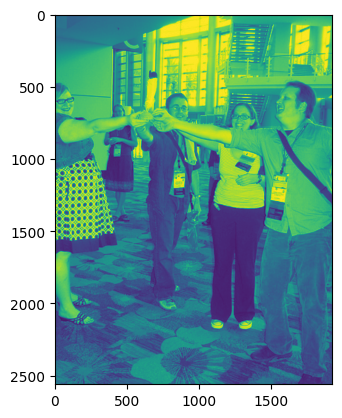

In [ ]:
img = cv2.imread("./mirflickr/im50.jpg" , 0)
img1 = imutils.resize(img, width=1920)
img2 = cv2.resize(img, (572,572), interpolation = cv2.INTER_AREA)
img3 = crop_square(img, 572)

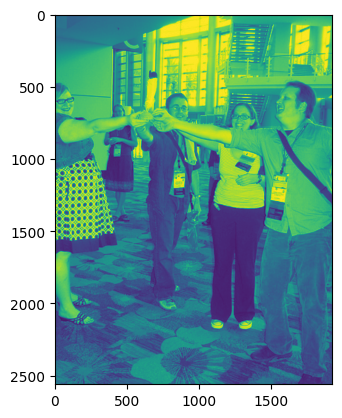

In [ ]:
plt.imshow(img1)

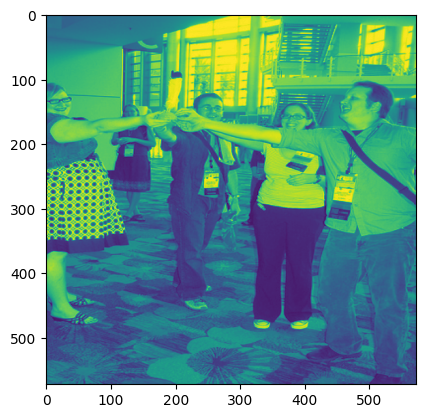

In [ ]:
plt.imshow(img2)

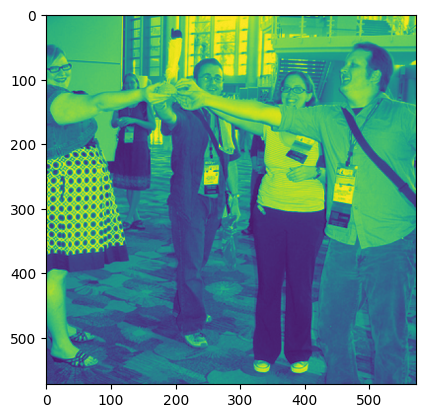

In [ ]:
plt.imshow(img3)